# The problem 
We have been reweighting the samples so that they are approximately flat with respect to pt. We do this by plotting the histogram of pt, and then scaling each sample by the inverse of its density in the histogram. Note that we carry out this procedure separately for the signal and background. First, let's see what the pt values look like for the signal and background distributions.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

array_dict = np.load('pts.npz')
pts_0 = array_dict['pts_0']
pts_1 = array_dict['pts_1']
pt_min, pt_max = 250, 300
bins = 50

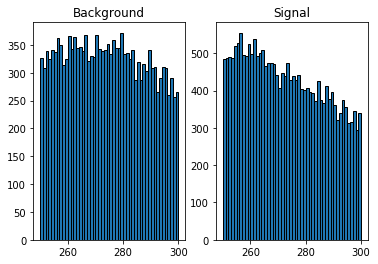

In [2]:
def histplot(x, ax, title, x_min, x_max, bins, weights=None):
    pdf, edges = np.histogram(x, density=False, range=[x_min, x_max], bins=bins, weights=weights)
    ax.bar(edges[:-1], pdf, width=np.diff(edges), ec="k", align="edge")
    ax.set_title(title)

fig, axs = plt.subplots(1,2)

histplot(pts_0, axs[0], 'Background', pt_min, pt_max, bins)
histplot(pts_1, axs[1], 'Signal', pt_min, pt_max, bins)

Now we will compute the weights and demonstrate that they do indeed normalize the distribution of pt.

In [3]:
def get_weights_for_flatness_in_pt(pts, pt_min, pt_max, bins):
    pdf, edges = np.histogram(pts, density=True, range=[pt_min, pt_max], bins=bins)
    indices = np.searchsorted(edges, pts) - 1
    inv_w = 1. / pdf[indices]
    inv_w /= inv_w.sum()
    return inv_w

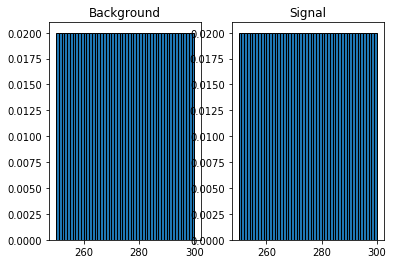

In [4]:
w_0 = get_weights_for_flatness_in_pt(pts_0,pt_min,pt_max,bins)
w_1 = get_weights_for_flatness_in_pt(pts_1,pt_min,pt_max,bins)
fig, axs = plt.subplots(1,2)
histplot(pts_0, axs[0], "Background", pt_min, pt_max, bins, weights=w_0)
histplot(pts_1, axs[1], "Signal", pt_min, pt_max, bins, weights=w_1)
plt.show()

Our overall function for getting the normalization weights should thus be: 

First, compute the weights with respect to the signal and background distributions.
~~~~
y = np.array([jet.y for jet in jets]) # this is the signal/background indicator

pts_0 = [jet.pt for jet in jets if jet.y == 0]
pts_1 = [jet.pt for jet in jets if jet.y == 1]

w_0 = get_weights_for_flatness_in_pt(pts_0, pt_min, pt_max, bins)
w_1 = get_weights_for_flatness_in_pt(pts_1, pt_min, pt_max, bins)
~~~~

Second, store all of these in a single array of the same shape as the jet indicator array.
~~~~
w = np.zeros(len(jets))

w[y==0] = w_0

w[y==1] = w_1
~~~~

**However**, we were not doing this. Rather, I had two loops over the jets as follows:
~~~~
w = np.zeros(len(jets))

for i, (iw, jet) in enumerate(zip(w_0, jets)):
    if jet.y == 0:
        w[i] = iw
        
for i, (iw, jet) in enumerate(zip(w_1, jets)):
    if jet.y == 1:
        w[i] = iw

~~~~

As you can see, this is **not** right. 

1) It writes the background jet weights into the first len(w_0) entries of w, provided that the corresponding jet is background.

2) Then it writes the signal jet weights into the first len(w_1) entries of w, provided that the corresponding jet is signal.

3) It never writes any weights to the array after place max(len(w_0), len(w_1)). These remain zero.

## Consequences
All of the results I achieved before hand were with the **incorrect** weighting. With this I got to 1/FPR = 150 at times.
Now that I have taken out the weighting, it is down to the 70s. So the question is - why does it have this positive effect on the metric? All it does is zero out about half the samples, which should just mean higher variance.